# Cuadernillo: Desbalanceo de clase
**Autor:** Gaddiel Esteban Nieto Rojas • **Fecha:** 2025-11-20

El cuadernillo presenta un proceso completo de análisis de morosidad crediticia basado en datos históricos, aplicando técnicas de preprocesamiento, balanceo y modelamiento supervisado. A través del uso de Python, Power BI y modelos predictivos, se busca identificar los factores más influyentes en la probabilidad de incumplimiento de pago.

> **Objetivos**
1. **Limpieza y preparación de datos:**  
   Se estandarizó la base de morosidad, corrigiendo valores faltantes y errores de formato.

2. **Análisis exploratorio:**  
   Se estudió la distribución de las variables financieras y sociodemográficas, detectando patrones relevantes.

3. **Análisis bivariado:**  
   Se evaluó la relación entre la variable objetivo (*morosidad*) y las variables explicativas.

4. **Balanceo de clases:**  
   Se aplicó la técnica **SMOTE** para equilibrar las proporciones entre clientes morosos y no morosos.

5. **Modelamiento predictivo:**  
   Se entrenaron y compararon modelos de **regresión logística**, **árbol de decisión** y **bosque aleatorio**.

6. **Evaluación del desempeño:**  
   Se seleccionó el modelo con mejor rendimiento según métricas como **F1-Score** y **AUC-ROC**.

7. **Visualización y presentación:**  
   Se exportaron los resultados a **Power BI** y se generó un resumen automático mediante la **API de Groq**, permitiendo interpretar los hallazgos de forma visual y ejecutiva.

In [ ]:
from Funciones import build_sqlite_from_excels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import sqlite3

In [ ]:
DB_PATH = "data.sqlite"

if not os.path.exists(DB_PATH):
    build_sqlite_from_excels(resources_dir="Resources", db_path=DB_PATH)

conn = sqlite3.connect(DB_PATH)
train = pd.read_sql("SELECT * FROM train", conn)
test = pd.read_sql("SELECT * FROM test", conn)
sample = pd.read_sql("SELECT * FROM sample", conn)
conn.close()

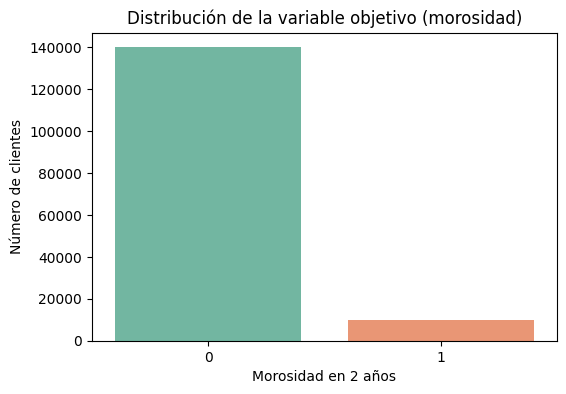

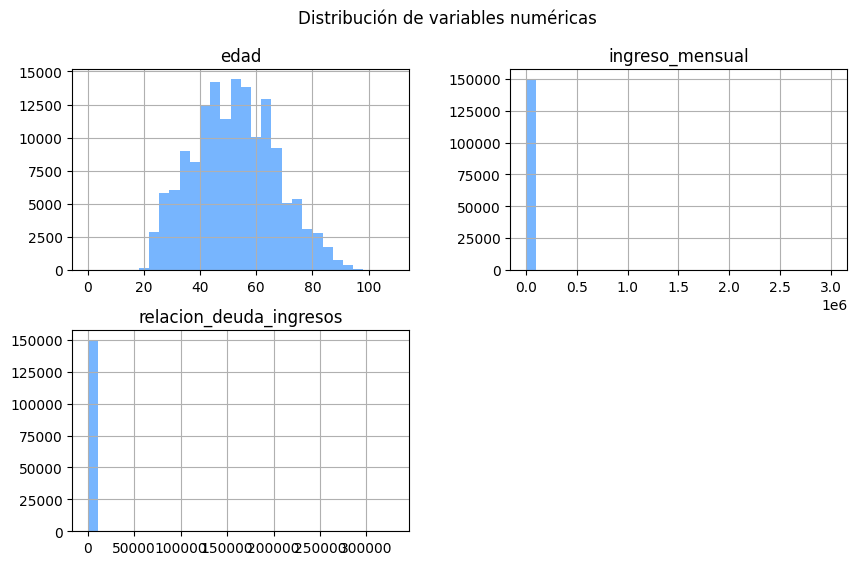

In [87]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x="morosidad_en_2_años", palette="Set2")
plt.title("Distribución de la variable objetivo (morosidad)")
plt.xlabel("Morosidad en 2 años")
plt.ylabel("Número de clientes")
plt.show()


cols = ["edad", "ingreso_mensual", "relacion_deuda_ingresos"]
train[cols].hist(figsize=(10,6), bins=30, color='#77b5fe')
plt.suptitle("Distribución de variables numéricas")
plt.show()

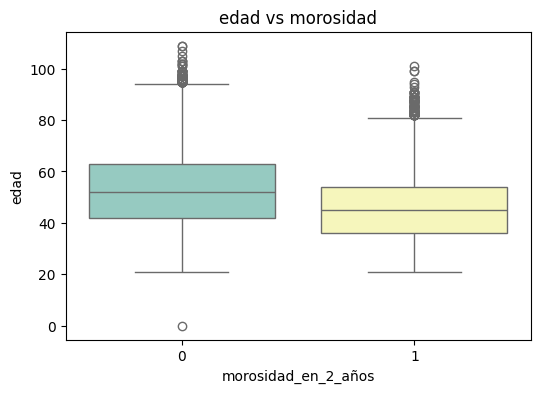

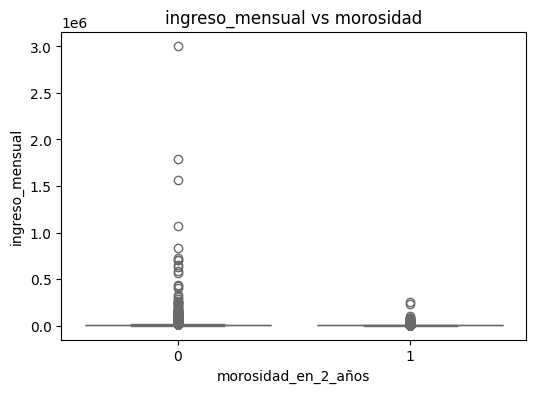

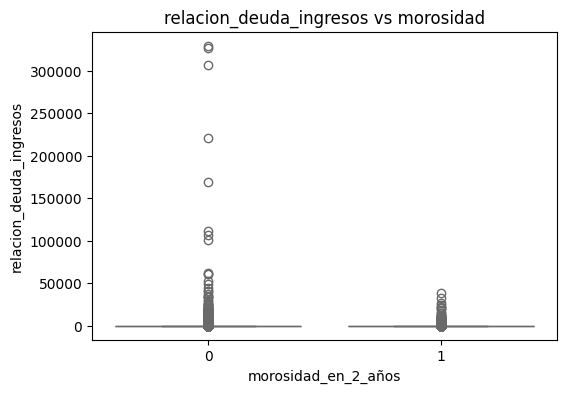

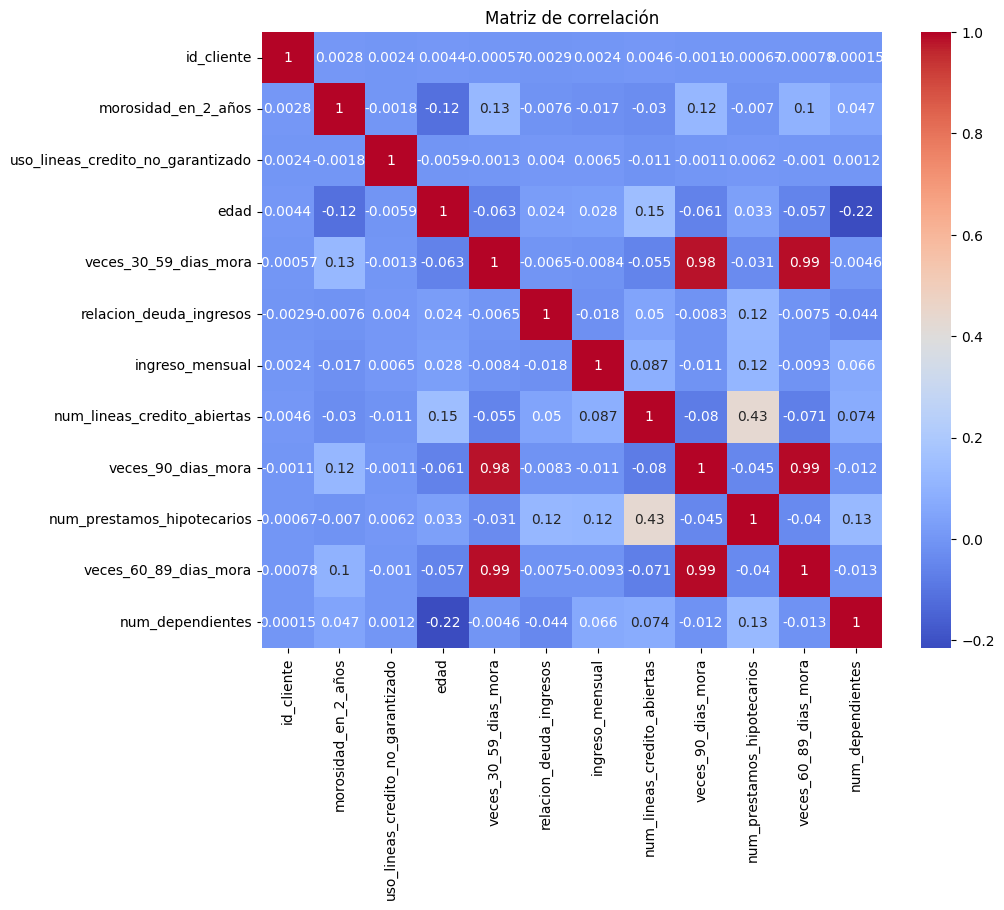

In [88]:
for col in ["edad", "ingreso_mensual", "relacion_deuda_ingresos"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="morosidad_en_2_años", y=col, data=train, palette="Set3")
    plt.title(f"{col} vs morosidad")
    plt.show()


plt.figure(figsize=(10,8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

In [ ]:
X = train.drop(columns=["morosidad_en_2_años", "id_cliente"])
y = train["morosidad_en_2_años"]

X = X.select_dtypes(include=[np.number]).copy()

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_entrenamiento_bal, y_entrenamiento_bal = smote.fit_resample(X_entrenamiento, y_entrenamiento)

scaler = StandardScaler()
X_entrenamiento_bal = pd.DataFrame(scaler.fit_transform(X_entrenamiento_bal), columns=X_entrenamiento.columns)
X_prueba = pd.DataFrame(scaler.transform(X_prueba), columns=X_prueba.columns)


Modelo: Regresion_Logistica
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     41992
           1       0.20      0.64      0.30      3008

    accuracy                           0.80     45000
   macro avg       0.58      0.73      0.60     45000
weighted avg       0.92      0.80      0.85     45000

AUC-ROC: 0.8009563324245145

Modelo: Arbol_Decision
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41992
           1       0.45      0.31      0.37      3008

    accuracy                           0.93     45000
   macro avg       0.70      0.64      0.67     45000
weighted avg       0.92      0.93      0.92     45000

AUC-ROC: 0.8380301011299518

Modelo: Bosque_Aleatorio
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     41992
           1       0.51      0.24      0.33      3008

    accuracy                           0.93    

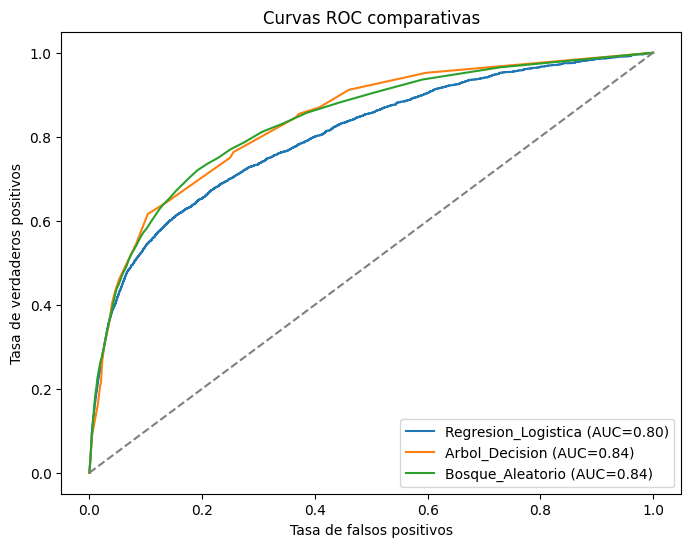

In [93]:
required = ["X_entrenamiento_bal", "y_entrenamiento_bal", "X_prueba", "y_prueba"]
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Faltan variables: {missing}. Ejecuta la celda de preprocesado antes de entrenar.")
if isinstance(X_entrenamiento_bal, pd.DataFrame) and X_entrenamiento_bal.shape[1] == 0:
    raise ValueError("X_entrenamiento_bal no tiene columnas válidas.")
if isinstance(X_prueba, pd.DataFrame) and X_prueba.shape[1] == 0:
    raise ValueError("X_prueba no tiene columnas válidas.")

modelos = {
    "Regresion_Logistica": LogisticRegression(max_iter=500),
    "Arbol_Decision": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Bosque_Aleatorio": RandomForestClassifier(n_estimators=100, random_state=42)
}

plt.figure(figsize=(8,6))
for nombre, modelo in modelos.items():
    modelo.fit(X_entrenamiento_bal, y_entrenamiento_bal)
    pred = modelo.predict(X_prueba)
    prob = modelo.predict_proba(X_prueba)[:, 1] if hasattr(modelo, "predict_proba") else modelo.decision_function(X_prueba)
    print(f"\nModelo: {nombre}")
    print(classification_report(y_prueba, pred))
    try:
        auc = roc_auc_score(y_prueba, prob)
        print("AUC-ROC:", auc)
    except Exception:
        auc = None
    fpr, tpr, _ = roc_curve(y_prueba, prob)
    label = f"{nombre} (AUC={auc:.2f})" if auc is not None else nombre
    plt.plot(fpr, tpr, label=label)

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Curvas ROC comparativas")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.show()

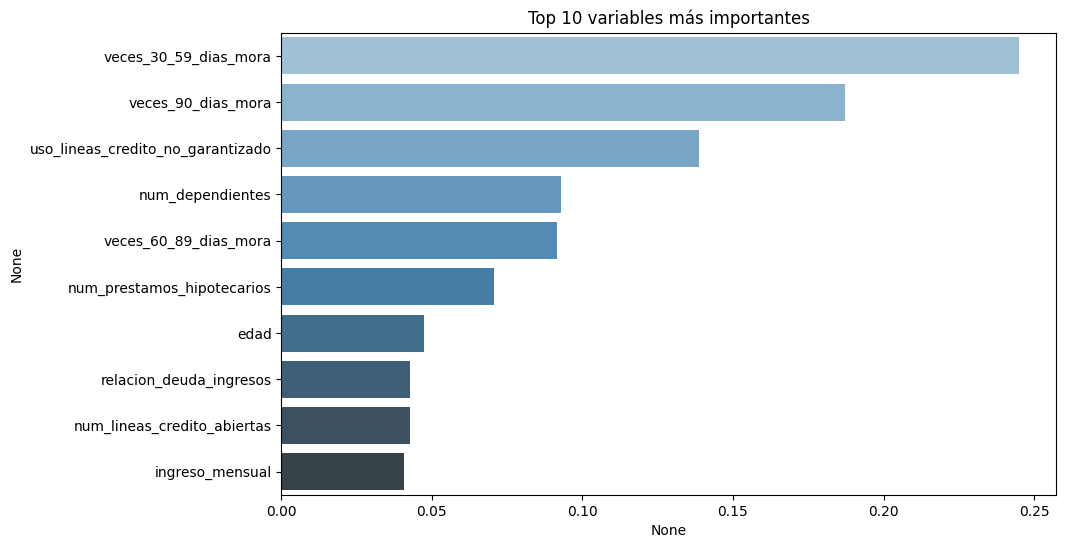

Exportación completada a carpeta PowerBI ✅


In [ ]:
importancias = modelos["Bosque_Aleatorio"].feature_importances_
importancia_vars = pd.Series(importancias, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=importancia_vars[:10], y=importancia_vars.index[:10], palette="Blues_d")
plt.title("Top 10 variables más importantes")
plt.show()


os.makedirs("PowerBI", exist_ok=True)
importancia_vars.to_excel("PowerBI/importancia_variables.xlsx", index=True)
train.to_excel("PowerBI/datos_limpios.xlsx", index=False)


print("Exportación completada a carpeta PowerBI ✅")